In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Download the required data : Annotations,Captions,Images

In [2]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 

In [3]:
os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (575/575), done.


Download the Annotations and Captions :

In [4]:
os.chdir('/content/opt/cocoapi')

# Download the annotation : 
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7f55d6c739e8>)

Extract Annotations from ZIP file

In [5]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


Initialize and verify the loaded data

In [6]:
os.chdir('/content/opt/cocoapi/annotations')
# initialize COCO API for instance annotations
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

instances_val2014.json
loading annotations into memory...
Done (t=4.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


plot a sample Image

In [7]:
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 

http://images.cocodataset.org/val2014/COCO_val2014_000000454382.jpg
Number of annotations i.e captions for the image:  [168868, 216949, 219721, 231967, 238819]

The blue dump truck rides down the street next to the houses.
A blue dump truck traveling down a street past tall houses.
A blue truck parked on the road near houses.
Dump truck alone on road with buildings and bare trees and shrubs behind it.
A blue dump truck sits parked on a residential street.


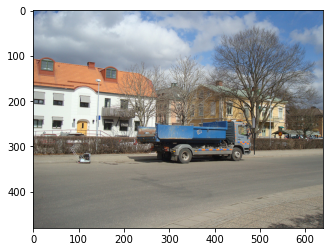

In [8]:
#Pick a random annotation id and display img of that annotation  :
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds( img_id   )
print('Number of annotations i.e captions for the image: ' , ann_ids)
print()
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)

Download Train , Test , Val Images :

In [9]:
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
urllib.request.urlretrieve( test2014 , 'test2014' )
#urllib.request.urlretrieve( val2014 , 'val2014' )


('test2014', <http.client.HTTPMessage at 0x7f559f9f37b8>)

unzip the download image zip files 

In [10]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None


os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'test2014' )
  print('zip removed')
except:
  None

zip removed
zip removed


## Step1 Explore the DataLoader

### Vocabulary.py

In [11]:
# vocabulary.py -------------------------------------------------------------
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

### data_loader.py

In [12]:
# Data Loader ---------------------------------------------------------------------------------------------

import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

### Dataloader creation

In [13]:
import sys
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from torchvision import transforms


# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 200

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
loading annotations into memory...
Done (t=2.43s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.64s)
creating index...


  0%|          | 878/414113 [00:00<00:47, 8778.61it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:46<00:00, 8832.24it/s]


In [14]:
import torch 
import numpy as np 
import torch.utils.data as data

In [15]:
# Exploring the dataloader now :


sample_caption = 'A person doing a trick xxxx on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize( sample_caption.lower() )

sample_caption = []
start_word  = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word
sample_tokens.insert(0 , start_word)
sample_tokens.append(end_word)
sample_caption.extend( [ data_loader_train.dataset.vocab(token) for token in sample_tokens ] )


sample_caption = torch.Tensor( sample_caption ).long()
print('Find Below the Sample tokens and the idx values of those tokens in word2idx' , '\n')
print(sample_tokens) 
print(sample_caption )

print('Find index values for words below \n')
print('Start idx {} , End idx {} , unknown idx {}'.format( 0,1,2 ))

Find Below the Sample tokens and the idx values of those tokens in word2idx 

['<start>', 'a', 'person', 'doing', 'a', 'trick', 'xxxx', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '<end>']
tensor([  0,   3,  97, 744,   3, 393,   2,  38,   3, 992, 205, 137,   3, 743,
         18,   1])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2


In [16]:
# Lets check word2idx in vocb 
print('First few vocab' , dict(list(data_loader_train.dataset.vocab.word2idx.items())[:10]))
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader_train.dataset.vocab))

First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 7073


<a id='step2'></a>
## Step 2: Use the Data Loader to Obtain Batches

The captions in the dataset vary greatly in length.  You can see this by examining `data_loader.dataset.caption_lengths`, a Python list with one entry for each training caption (where the value stores the length of the corresponding caption).  

In the code cell below, we use this list to print the total number of captions in the training data with each length.  As you will see below, the majority of captions have length 10.  Likewise, very short and very long captions are quite rare.  

In [17]:
from collections import Counter

counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000: 
    break

value 10  count 86334
value 11  count 79948
value  9  count 71934
value 12  count 57637
value 13  count 37645
value 14  count 22335
value  8  count 20771
value 15  count 12841
value 16  count  7729


To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset).  Then, we retrieve a batch of size `batch_size` of image-caption pairs, where all captions have the sampled length.  This approach for assembling batches matches the procedure in [this paper](https://arxiv.org/pdf/1502.03044.pdf) and has been shown to be computationally efficient without degrading performance.

Run the code cell below to generate a batch.  The `get_train_indices` method in the `CoCoDataset` class first samples a caption length, and then samples `batch_size` indices corresponding to training data points with captions of that length.  These indices are stored below in `indices`.

These indices are supplied to the data loader, which then is used to retrieve the corresponding data points.  The pre-processed images and captions in the batch are stored in `images` and `captions`.

In [18]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [364220, 241543, 319815, 116354, 114582, 307649, 115217, 16948, 51787, 226827, 73848, 126963, 250676, 9538, 61102, 127666, 185651, 59314, 133641, 261485, 264340, 289678, 149341, 402152, 335108, 407115, 157272, 6151, 6600, 372761, 311533, 28604, 192585, 289947, 354326, 165509, 51134, 60859, 165878, 61715, 91975, 311726, 243462, 156881, 380643, 398269, 123678, 47498, 338653, 147094, 162088, 413379, 216311, 198913, 376596, 358961, 122811, 26997, 376488, 14894, 202376, 58856, 308987, 271161, 68161, 19618, 396538, 156274, 309753, 45759, 211793, 305514, 337269, 292970, 331635, 311510, 208640, 105570, 293107, 108782, 191947, 132584, 367952, 208657, 220552, 84165, 267140, 355447, 210245, 255111, 119437, 173160, 60367, 241446, 4949, 52803, 405757, 310024, 90704, 411894, 408404, 290443, 298771, 242154, 140971, 199808, 236390, 253064, 9524, 21141, 8932, 307443, 28445, 371693, 202967, 176705, 75601, 323405, 97186, 381356, 362725, 166656, 118944, 115961, 388047, 239326, 378820, 1626

<a id='step3'></a>
## Step 3: Experiment with the CNN Encoder


The encoder uses the pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images.  The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding.



In [19]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features
    

In [20]:
# specify dim of image embedding
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images=  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



<class 'torch.Tensor'> torch.Size([200, 256]) torch.Size([200, 3, 224, 224])


<a id='step4'></a>
## Step 4: Implement the RNN Decoder


In the code cell below, `outputs` should be a PyTorch tensor with size `[batch_size, captions.shape[1], vocab_size]`.  Your output should be designed such that `outputs[i,j,k]` contains the model's predicted score, indicating how likely the `j`-th token in the `i`-th caption in the batch is the `k`-th token in the vocabulary.  In the next notebook of the sequence (**2_Training.ipynb**), we provide code to supply these scores to the [`torch.nn.CrossEntropyLoss`](http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) optimizer in PyTorch.

In [21]:
import os 
import torch.utils.data as data 
import torch 
import math
import pickle
import matplotlib.pyplot as plt 
% matplotlib inline

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_ouput) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

In [23]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 4
print_every = 150
save_every = 1 
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )


decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )



device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import sys 
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )


Epochs [1/4] Step [0/2071] Loss [8.8806] 
Epochs [1/4] Step [150/2071] Loss [4.0232] 
Epochs [1/4] Step [300/2071] Loss [3.5489] 


Load the saved checkpoint 

In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(  os.path.join(model_save_path , 'decoder_input_params_12_19_2019.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(1) )   ) )

decoder = DecoderRNN( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(1) )   ) )



Create Dataloader for test data :

In [ ]:
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_test)

In [ ]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

In [ ]:
encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )

features  = encoder(processed_img.to(device)   ).unsqueeze(1)
final_output = decoder.predict( features  , max_len=20)
get_sentences(original_img, final_output)